# K80. Chainer CIFAR100 benchmark
## Combined profile

Profiled on p2.xlarge (K80), CUDA9.0
```
python train_cifar.py -d cifar100 -g 0 -b 256 -e 2
```

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path
import datetime
from cycler import cycler
import pandas as pd

# Plot combined profiling

In [2]:
time_field_index = 0
duration_field_index = 1
SSMem_field_index = 9
DSMem_field_index = 10
size_field_index = 11
throughput_field_index = 12
src_field_index = 13
dst_field_index = 14
context_index = 16
stream_index = 17
name_field_index = 18

title_pattern = re.compile("^(Start|s).*")
cuda_pattern = re.compile("\[CUDA .*\]")

columns = [time_field_index, duration_field_index,
           size_field_index, throughput_field_index,
           src_field_index, dst_field_index,
           context_index, stream_index,
           name_field_index]

maxrows = None

In [3]:
!ls *.csv

TFHP_combined_v100-nvidia-smi.csv
TFHP_combined_v100-nvprof-trace-13124.csv
TFHP_combined_v100_50ms-nvidia-smi.csv
TFHP_combined_v100_50ms-nvprof-trace-13339.csv
chainer_K80_b256_combined-nvidia-smi.csv
chainer_K80_b256_combined-nvprof-trace-12001.csv


In [4]:
filename_nvsmi_tf = "chainer_K80_b256_combined-nvidia-smi.csv"
filename_nvprof_tf = "chainer_K80_b256_combined-nvprof-trace-12001.csv"

df_nvprof = pd.read_csv(filename_nvprof_tf,header = 0, usecols = columns, skiprows=[0,1,2,4], nrows = maxrows)
df_nvprof.iloc[-5:]

,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
116297,462.181070,0.003776,0.000488,0.126281,Device,Pageable,1,7,[CUDA memcpy DtoH]
116298,462.181112,0.003871,0.000488,0.123182,Device,Pageable,1,7,[CUDA memcpy DtoH]
116299,462.181153,0.003840,0.000488,0.124176,Device,Pageable,1,7,[CUDA memcpy DtoH]
116300,462.181193,0.003776,0.000488,0.126281,Device,Pageable,1,7,[CUDA memcpy DtoH]
116301,462.181240,0.040669,0.281250,6.753503,Device,Pageable,1,7,[CUDA memcpy DtoH]


# Remove rows with no Throughput

In [5]:
df_nvprof = df_nvprof.loc[df_nvprof["Throughput"].notnull()]
df_nvprof.iloc[-5:]

,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
116297,462.181070,0.003776,0.000488,0.126281,Device,Pageable,1,7,[CUDA memcpy DtoH]
116298,462.181112,0.003871,0.000488,0.123182,Device,Pageable,1,7,[CUDA memcpy DtoH]
116299,462.181153,0.003840,0.000488,0.124176,Device,Pageable,1,7,[CUDA memcpy DtoH]
116300,462.181193,0.003776,0.000488,0.126281,Device,Pageable,1,7,[CUDA memcpy DtoH]
116301,462.181240,0.040669,0.281250,6.753503,Device,Pageable,1,7,[CUDA memcpy DtoH]


In [6]:
print df_nvprof.shape
print df_nvprof.Name.unique()

(6277, 9)
['[CUDA memcpy HtoD]' '[CUDA memset]' '[CUDA memcpy DtoH]']


In [7]:
nvprof = df_nvprof.loc[~df_nvprof["Name"].str.contains("memset")]
print nvprof.Name.unique()

['[CUDA memcpy HtoD]' '[CUDA memcpy DtoH]']


### Group by SRC and DST memory type

In [8]:
#nvprof['FullName'] = nvprof['Name']
nvprof['FullName'] = nvprof['Name'] + " " + nvprof['SrcMemType']+ nvprof['DstMemType'].fillna("")
nvprof.drop(['Name'], axis=1, inplace=True)
print nvprof.FullName.unique()
print nvprof.shape
nvprof.iloc[:15]

['[CUDA memcpy HtoD] PinnedDevice' '[CUDA memcpy HtoD] PageableDevice'
 '[CUDA memcpy DtoH] DevicePageable']
(1150, 9)


/Users/peterbryzgalov/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/peterbryzgalov/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,FullName
0,0.288554,0.002751,0.001953,0.693329,Pinned,Device,1,7,[CUDA memcpy HtoD] PinnedDevice
1,0.288774,0.002048,0.001953,0.931323,Pinned,Device,1,7,[CUDA memcpy HtoD] PinnedDevice
2,0.288955,0.002016,0.001953,0.946105,Pinned,Device,1,7,[CUDA memcpy HtoD] PinnedDevice
3,0.289078,0.002016,0.001953,0.946105,Pinned,Device,1,7,[CUDA memcpy HtoD] PinnedDevice
4,0.289198,0.002016,0.001953,0.946105,Pinned,Device,1,7,[CUDA memcpy HtoD] PinnedDevice
5,0.289313,0.002048,0.001953,0.931323,Pinned,Device,1,7,[CUDA memcpy HtoD] PinnedDevice
6,0.289512,0.002016,0.001953,0.946105,Pinned,Device,1,7,[CUDA memcpy HtoD] PinnedDevice
7,0.289628,0.002048,0.001953,0.931323,Pinned,Device,1,7,[CUDA memcpy HtoD] PinnedDevice
8,0.289744,0.002048,0.001953,0.931323,Pinned,Device,1,7,[CUDA memcpy HtoD] PinnedDevice
9,0.289854,0.002047,0.001953,0.931778,Pinned,Device,1,7,[CUDA memcpy HtoD] PinnedDevice


In [9]:
throughput = nvprof.rename(columns={"Start":"sec"})
throughput.drop(throughput.columns[[1,2,4,5,6,7]],axis=1,inplace=True)
throughput.iloc[:3]

,sec,Throughput,FullName
0,0.288554,0.693329,[CUDA memcpy HtoD] PinnedDevice
1,0.288774,0.931323,[CUDA memcpy HtoD] PinnedDevice
2,0.288955,0.946105,[CUDA memcpy HtoD] PinnedDevice


In [10]:
throughput.set_index("sec",drop=True,inplace=True)
throughput.iloc[:3]

,Throughput,FullName
sec,,
0.288554,0.693329,[CUDA memcpy HtoD] PinnedDevice
0.288774,0.931323,[CUDA memcpy HtoD] PinnedDevice
0.288955,0.946105,[CUDA memcpy HtoD] PinnedDevice


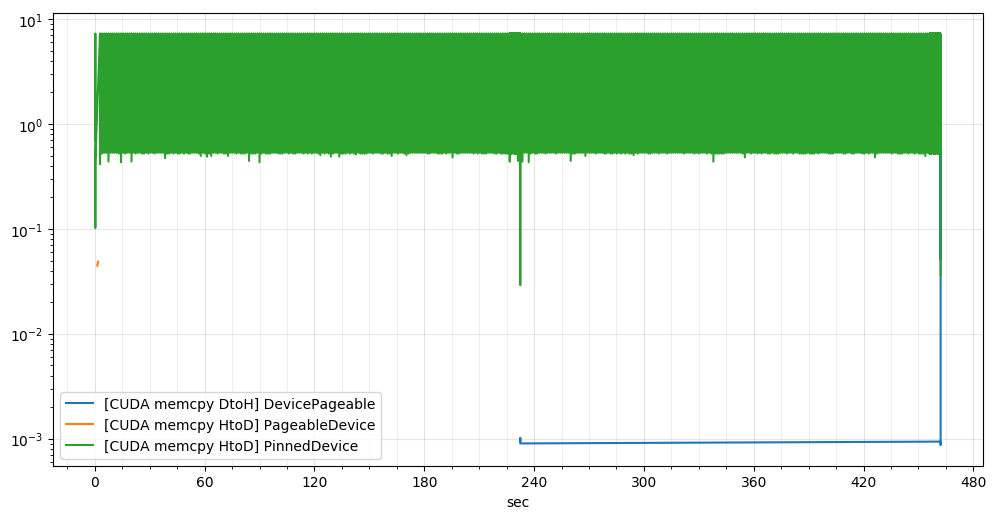

In [11]:
# Split one dataframe into several by names in FullName
fig, ax = plt.subplots(figsize=(12,6))
#throughput.groupby("FullName").plot()
for label, df in throughput.groupby("FullName"):
#     print label,type(df)
#     print df.iloc[:1]
    df.plot(ax=ax, y="Throughput",label=label,logy=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.xaxis.set_minor_locator(plt.MaxNLocator(50))
ax.xaxis.grid(linewidth=0.5,alpha=0.3,which="both")
ax.yaxis.grid(alpha=0.3)
plt.legend()

In [76]:
dh = nvprof.loc[~nvprof["FullName"].str.contains("DtoD")]
print dh.shape
dh.iloc[-3:]

(1150, 9)


,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,FullName
116299,462.181153,0.003840,0.000488,0.124176,Device,Pageable,1,7,[CUDA memcpy DtoH] DevicePageable
116300,462.181193,0.003776,0.000488,0.126281,Device,Pageable,1,7,[CUDA memcpy DtoH] DevicePageable
116301,462.181240,0.040669,0.281250,6.753503,Device,Pageable,1,7,[CUDA memcpy DtoH] DevicePageable


In [77]:
dh["Throughput"].median()

0.532184

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x107a6e490>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10bc964d0>]], dtype=object)

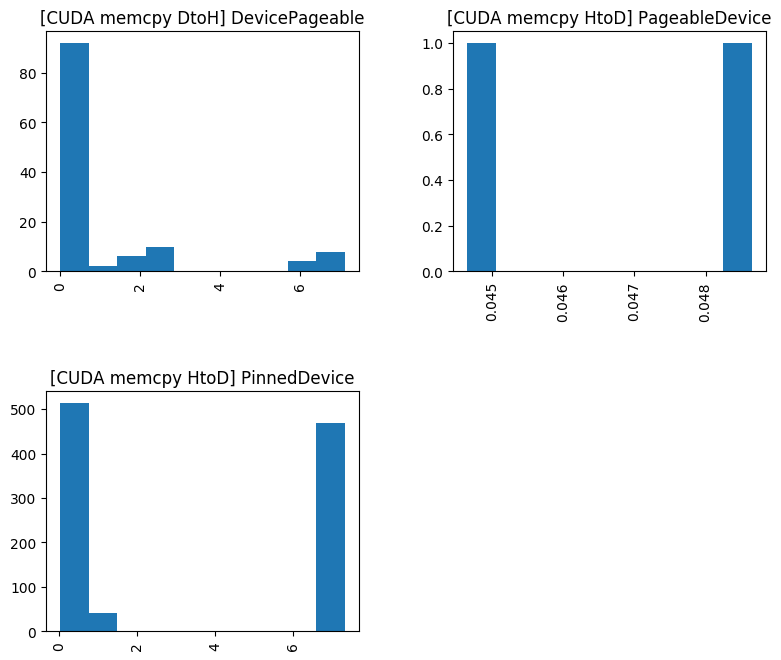

In [79]:
dh.hist(column="Throughput",by="FullName",figsize=(9,8))

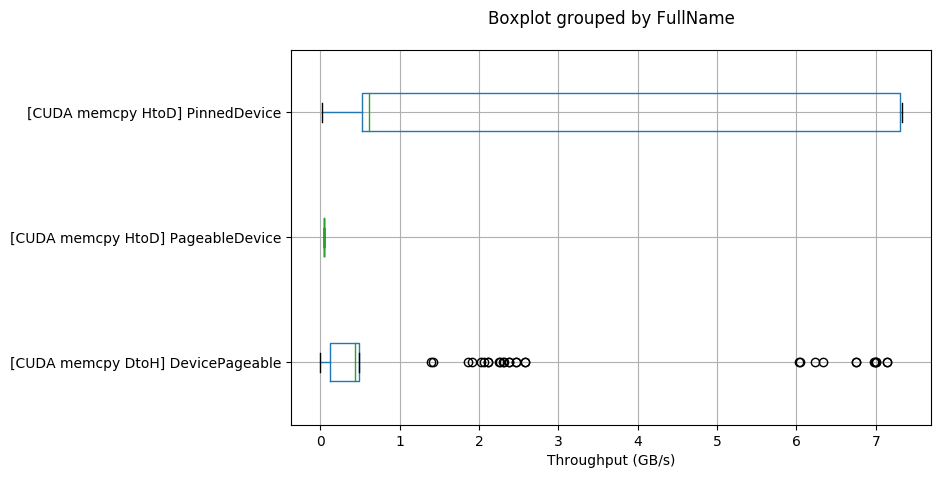

In [102]:
plt.rcParams['figure.figsize'] = 8,5
fig, ax = plt.subplots(1,1)
plot = dh.boxplot(column="Throughput",by="FullName",ax=ax,vert=False,fontsize=10)
# Print all plot properties
#prop = plot.properties()
#print type(prop)
#for key,val in prop.iteritems():
#    print key,"=",val
ax.set_xlabel('Throughput (GB/s)',size=10)
ax.set_title("")
plt.show()

In [22]:
# Convert unique values in column "FullName" to new columns
def mergeColumnNames(df_org):
    df = df_org.pivot(index="Start", columns="FullName", values = 'Throughput')
    df = df.fillna(0)  # Fill empty cells with 0-s
    return df

In [23]:
df_throughput = mergeColumnNames(nvprof)
df_throughput.iloc[:3]

FullName,[CUDA memcpy DtoH] DevicePageable,[CUDA memcpy HtoD] PageableDevice,[CUDA memcpy HtoD] PinnedDevice
Start,,,
0.288554,0.0,0.0,0.693329
0.288774,0.0,0.0,0.931323
0.288955,0.0,0.0,0.946105


In [24]:
def appendMaxValues2ColumnNames(df,series):
    cols = len(df.columns)
    col_names = []
    for i in range(0,cols):
        name = df.columns[i].replace("[CUDA memcpy ","")
        name = name.replace("]","")
        col_names.append(series+name+" " +'{:.3f}'.format(df.iloc[:,i].max()))
    df.columns = col_names
    return df

In [25]:
df_throughput = appendMaxValues2ColumnNames(df_throughput,"")
df_throughput.columns

Index([u'DtoH DevicePageable 7.134', u'HtoD PageableDevice 0.049',
       u'HtoD PinnedDevice 7.329'],
      dtype='object')

##### Rename Start column

In [26]:
df_throughput.index.names = ["sec"]

In [29]:
dh = df_throughput.filter(regex=(".*(HtoD|DtoH).*"))
dh.iloc[:3]

,DtoH DevicePageable 7.134,HtoD PageableDevice 0.049,HtoD PinnedDevice 7.329
sec,,,
0.288554,0.0,0.0,0.693329
0.288774,0.0,0.0,0.931323
0.288955,0.0,0.0,0.946105


Text(0,0.5,u'Throughput (GB/s)')

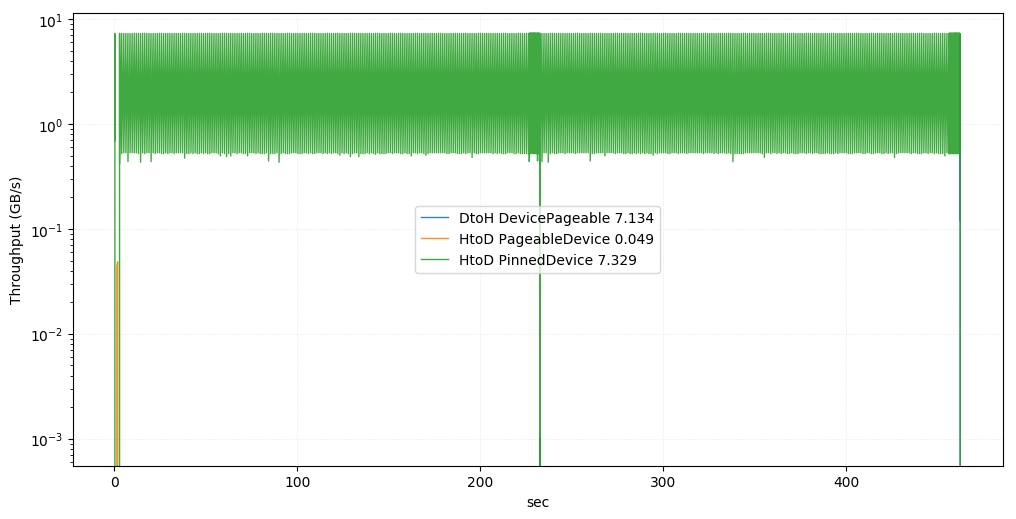

In [36]:
plt.rcParams['figure.figsize'] = 12,6
dh.plot(linewidth=1,alpha=0.9,logy=True)
ax = plt.gca()
ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.set_ylabel('Throughput (GB/s)')

In [38]:
# PCI express x3 bandwidth
PCI3_band = 16 # GB/s

In [39]:
# Device DRAM bandwidth
# Memory clock rate
GHz=5
# Interface width
bit=384

DRAM_GBs=(GHz * 1e9 * (bit/8)) / 1e9
print PCI3_band, DRAM_GBs

16 240.0


#### Normalize H<->D throughput

In [47]:
norm = df_throughput.copy()
def normalize(x,max = 16):
    #print "max=",max 
    if isinstance(x,int) or isinstance(x,float):
        if x == 0:
            return 0
        else:
            x_ = float(x)
            max_ = float(max)
            norm = (x_/max_)*100
            #print x_,norm
            return norm
    elif x is None:
        return x
    else:
        print "Wrong parameter type:",type(x)

def normalize_df(x,max = 16):
    #print type(x)
    if isinstance(x,int) or isinstance(x,float):
        return normalize(x,max)
    else:
        #print x.values
        x = x.apply(normalize,max=max)
        #print "Returned:",type(x)
        #print x.values
        return x
    
       
norm.iloc[:,:] = norm.iloc[:,:].apply(normalize_df, max = PCI3_band)
#norm.iloc[:,0] = norm.iloc[:,0].apply(normalize_df, max = DRAM_GBs)
norm[df_throughput.iloc[:,0] > 7]

,DtoH DevicePageable 7.134,HtoD PageableDevice 0.049,HtoD PinnedDevice 7.329
sec,,,
462.118039,44.587663,0.0,0.0
462.144839,43.757681,0.0,0.0
462.151094,44.587663,0.0,0.0
462.180333,43.776094,0.0,0.0


In [49]:
dhnorm = dh.copy()
dhnorm = dhnorm.apply(normalize_df, max = PCI3_band)
dhnorm[dh.iloc[:,0] > 7]

,DtoH DevicePageable 7.134,HtoD PageableDevice 0.049,HtoD PinnedDevice 7.329
sec,,,
462.118039,44.587663,0.0,0.0
462.144839,43.757681,0.0,0.0
462.151094,44.587663,0.0,0.0
462.180333,43.776094,0.0,0.0


Text(0,0.5,u'Throughput (%)')

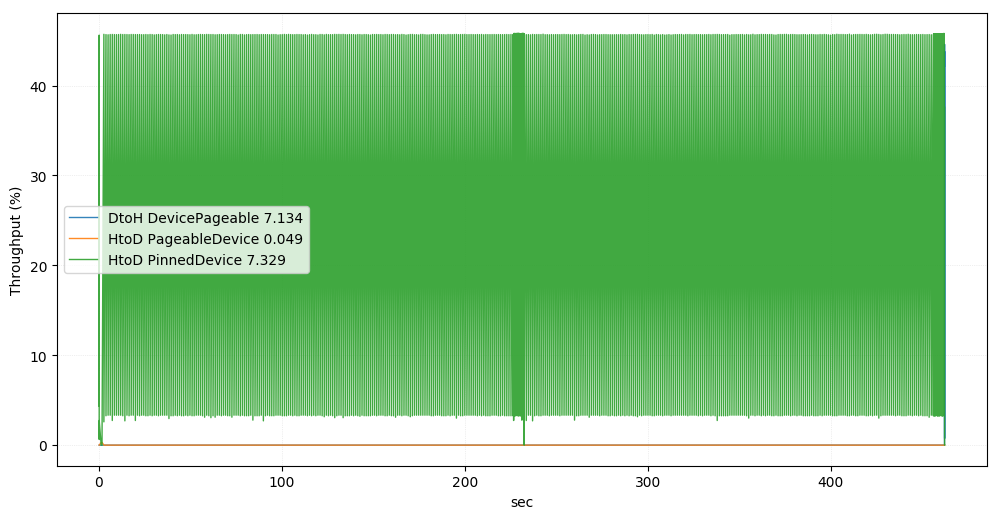

In [52]:
dhnorm.plot(linewidth=1,alpha=0.9,logy=False)
ax = plt.gca()
ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.set_ylabel('Throughput (%)')

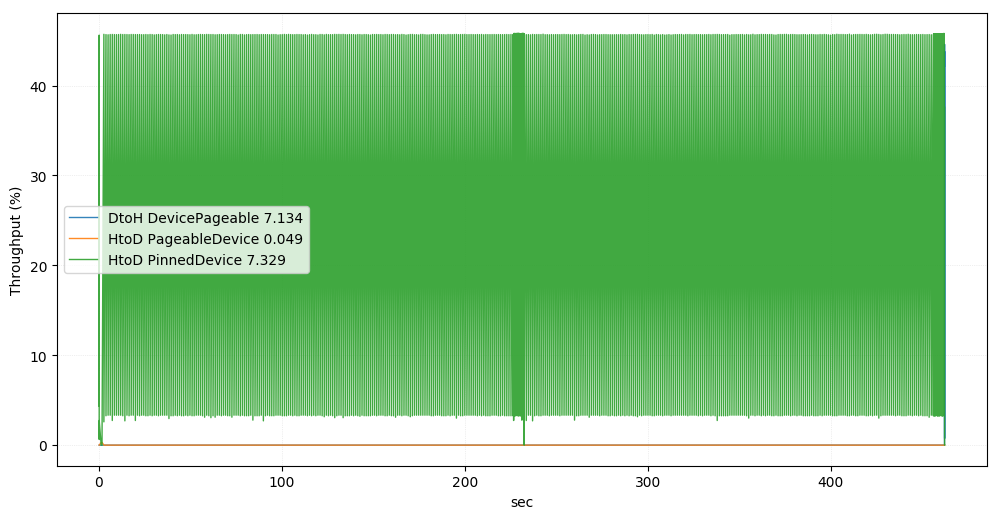

In [53]:
# plt.rcParams['figure.figsize'] = 12,8
# norm.plot(linewidth=0.9,alpha=0.8)
# ax = plt.gca()
# ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5,alpha=0.7)
# ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5,alpha=0.7)
# #ax.xaxis.set_major_locator(plt.MaxNLocator(24))
# ax.set_xlabel('Start (s)')
# ax.set_ylabel('Throughput (%)')
# plt.show()


plt.rcParams['figure.figsize'] = 12,6
fig, ax = plt.subplots(1)
norm.plot(linewidth=1,alpha=0.9,ax = ax,logy=False)
ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.set_ylabel('Throughput (%)')
plt.show()

# Plot smi data

In [57]:
filename = filename_nvsmi_tf
print "Reading",filename
start = 0
smi_data = pd.read_csv(filename,header=0)
smi_data.iloc[:3]

Reading chainer_K80_b256_combined-nvidia-smi.csv


,timestamp,name,memory.total [MiB],memory.used [MiB],utilization.gpu [%],utilization.memory [%],pcie.link.width.max,pcie.link.width.current
0,2018/02/13 08:16:57.372,Tesla K80,11439 MiB,0 MiB,98 %,5 %,16,16
1,2018/02/13 08:16:57.457,Tesla K80,11439 MiB,0 MiB,98 %,5 %,16,16
2,2018/02/13 08:16:57.520,Tesla K80,11439 MiB,0 MiB,98 %,5 %,16,16


In [61]:
# Parse date from readable format to seconds
def parseTime(date_time):
    global start
    dt_obj = datetime.datetime.strptime(date_time, "%Y/%m/%d %H:%M:%S.%f")
    seconds = 0
    if start == 0:
        start = dt_obj
    else:
        seconds = (dt_obj - start).total_seconds()
    return seconds

In [62]:
smi_data["sec"] = smi_data["timestamp"].apply(parseTime)
smi_data.iloc[:3]

,timestamp,name,memory.total [MiB],memory.used [MiB],utilization.gpu [%],utilization.memory [%],pcie.link.width.max,pcie.link.width.current,sec
0,2018/02/13 08:16:57.372,Tesla K80,11439 MiB,0 MiB,98 %,5 %,16,16,0.000
1,2018/02/13 08:16:57.457,Tesla K80,11439 MiB,0 MiB,98 %,5 %,16,16,0.085
2,2018/02/13 08:16:57.520,Tesla K80,11439 MiB,0 MiB,98 %,5 %,16,16,0.148


In [63]:
pat = re.compile("[0-9\.]+")
# Extract float number from a string
def parseFloat(str):
    global pat
    f = pat.search(str)
    if f is not None:
        d = float(f.group())
        return d
    return None

In [67]:
smi_data.columns

Index([u'timestamp', u' name', u' memory.total [MiB]', u' memory.used [MiB]',
       u' utilization.gpu [%]', u' utilization.memory [%]',
       u' pcie.link.width.max', u' pcie.link.width.current', u'sec'],
      dtype='object')

In [68]:
smi = smi_data.drop(columns = [' pcie.link.width.max', ' pcie.link.width.current', 'timestamp', ' name'])
print smi.iloc[:2]
smi.set_index("sec", drop=True, inplace=True)
smi.iloc[:3]

   memory.total [MiB]  memory.used [MiB]  utilization.gpu [%]  \
0           11439 MiB              0 MiB                 98 %   
1           11439 MiB              0 MiB                 98 %   

   utilization.memory [%]    sec  
0                     5 %  0.000  
1                     5 %  0.085  


,memory.total [MiB],memory.used [MiB],utilization.gpu [%],utilization.memory [%]
sec,,,,
0.000,11439 MiB,0 MiB,98 %,5 %
0.085,11439 MiB,0 MiB,98 %,5 %
0.148,11439 MiB,0 MiB,98 %,5 %


In [69]:
smi = smi.applymap(parseFloat)
smi.iloc[:3]

,memory.total [MiB],memory.used [MiB],utilization.gpu [%],utilization.memory [%]
sec,,,,
0.000,11439.0,0.0,98.0,5.0
0.085,11439.0,0.0,98.0,5.0
0.148,11439.0,0.0,98.0,5.0


In [70]:
#Mib to GB conversion: 1 MiB = 0.001048576 GB (1MiB=2^20=1 048 576 bytes, 1GB = 1 000 000 000 bytes
smi.iloc[:,[0,1]] = smi.iloc[:,[0,1]].apply(lambda x: x*0.001048576)
smi.rename(columns={smi.columns[0]:"Total Memory (GB)", smi.columns[1]:"Used Memory (GB)"}, inplace=True)
smi.iloc[:3]

,Total Memory (GB),Used Memory (GB),utilization.gpu [%],utilization.memory [%]
sec,,,,
0.000,11.994661,0.0,98.0,5.0
0.085,11.994661,0.0,98.0,5.0
0.148,11.994661,0.0,98.0,5.0


In [72]:
Mem = smi.iloc[:,[0,1]]
Util = smi.iloc[:,[2,3]]
Mem.iloc[-5:]

,Total Memory (GB),Used Memory (GB)
sec,,
396.289,11.994661,1.531970
396.340,11.994661,1.531970
396.390,11.994661,1.529872
396.441,11.994661,1.529872
396.491,11.994661,0.011534


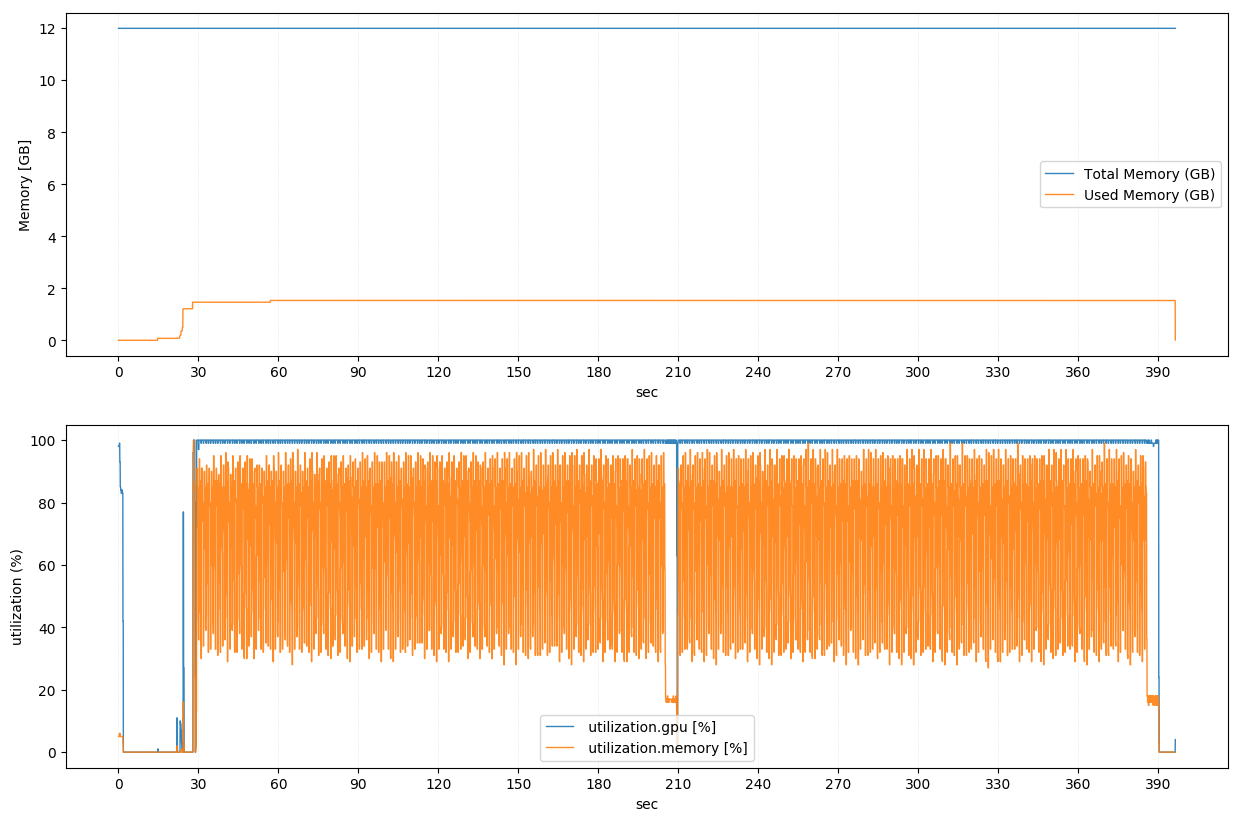

In [75]:
plt.rcParams['figure.figsize'] = 15,10
fig, axarr = plt.subplots(2)
Mem.plot(linewidth=1,alpha=0.9,ax = axarr[0])
Util.plot(linewidth=1,alpha=0.9,ax = axarr[1])
axarr[0].set_ylabel('Memory [GB]')
axarr[1].set_ylabel('utilization (%)')
for axis in axarr:
    axis.legend()
    axis.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    axis.xaxis.set_major_locator(plt.MaxNLocator(16))
    #axis.xaxis.set_major_locator(dates.SecondLocator(bysecond = range(120), interval = 10))
    #axis.xaxis.set_minor_locator(dates.MicrosecondLocator(interval = 1000))
    #axis.xaxis.set_major_formatter(dates.DateFormatter('%S:%f'))
plt.show()